# ZINB Graphical Model Tutorial

This notebook provides an in-depth tutorial on the `zinb_graphical_model` Python package for modeling gene-gene interactions using Zero-Inflated Negative Binomial (ZINB) distributions with pseudo-likelihood inference.

**Contents:**
1. [Installation & Setup](#installation)
2. [Background & Theory](#theory)
3. [Data Preparation](#data)
4. [Model Setup](#model)
5. [MCMC Inference](#inference)
6. [Posterior Analysis](#posterior)
7. [Network Inference from Ω](#network-inference)
8. [Network Analysis with NetworkX](#network-analysis)

<a id='installation'></a>
## 1. Installation & Setup

Install the package from the local path and configure the compute device.

In [1]:
# Install the zinb_graphical_model package from local source
# Run this cell once to install
%pip install -e /Users/mcelfreg/Library/CloudStorage/OneDrive-OregonHealth\&ScienceUniversity/scRNASeq_OneDrive/PreGraphModeling/python --break-system-packages

Obtaining file:///Users/mcelfreg/Library/CloudStorage/OneDrive-OregonHealth%26ScienceUniversity/scRNASeq_OneDrive/PreGraphModeling/python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for zinb_graphical_model (pyproject.toml) ... done
  Created wheel for zinb_graphical_model: filename=zinb_graphical_model-0.1.1-0.editable-py3-none-any.whl size=4562 sha256=fa538a1be2e0d4c86712a628ed2a336d34ba15474eed9ec8139000b00142deb5
  Stored in directory: /private/var/folders/z3/8cm3bfq97jlfg1tvgxyz3b2nwd1khd/T/pip-ephem-wheel-cache-b3ed7ur8/wheels/8b/b9/a7/3ea6d6714a4156f7d3bff3ac181bc898e59d6bfbef5d1b2961
Successfully built zinb_graphical_model
  Attempting uninstall: zinb_graphical_model
    Found existing installation: zinb_graphical_model 0.1.1
    Uninstalling zinb_graphical_model-0.1.1:
      Successfully uninstal

In [2]:
# Additional dependencies for visualization and network analysis
%pip install matplotlib seaborn networkx pandas --break-system-packages

Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
import numpy as np
import pandas as pd
import torch
import pyro
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path

# Import our package
from zinb_graphical_model import (
    ZINBPseudoLikelihoodGraphicalModel,
    run_inference,
    load_count_matrix,
)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"Pyro version: {pyro.__version__}")
print(f"zinb_graphical_model loaded successfully!")

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1
Pyro version: 1.9.1
zinb_graphical_model loaded successfully!


### Device Selection: MPS (Mac Silicon), CUDA, or CPU

Mac Silicon GPUs support Metal Performance Shaders (MPS) through PyTorch. We'll attempt MPS first, with automatic fallback to CPU if issues arise.

In [4]:
def get_best_device():
    """
    Detect the best available compute device.
    Priority: CUDA > MPS (Mac Silicon) > CPU
    """
    if torch.cuda.is_available():
        device = "cuda"
        device_name = torch.cuda.get_device_name(0)
        print(f"✓ CUDA available: {device_name}")
    elif torch.backends.mps.is_available():
        device = "mps"
        print("✓ MPS (Mac Silicon GPU) available")
        print("  Note: Pyro's NUTS sampler may have limited MPS optimization.")
        print("  If inference fails, we'll fall back to CPU.")
    else:
        device = "cpu"
        print("ℹ Using CPU (no GPU detected)")
    return device

# Detect device
DEVICE = get_best_device()
print(f"\nSelected device: {DEVICE}")

✓ MPS (Mac Silicon GPU) available
  Note: Pyro's NUTS sampler may have limited MPS optimization.
  If inference fails, we'll fall back to CPU.

Selected device: mps


<a id='theory'></a>
## 2. Background & Theory

### Zero-Inflated Negative Binomial (ZINB) Distribution

Single-cell RNA-seq count data exhibits:
- **Overdispersion**: Variance exceeds the mean (unlike Poisson)
- **Zero-inflation**: More zeros than expected from any standard count distribution

The ZINB distribution models this as a mixture:

$$P(X = x | \mu, \phi, \pi) = \begin{cases} 
\pi + (1-\pi) \cdot NB(0 | \mu, \phi) & \text{if } x = 0 \\
(1-\pi) \cdot NB(x | \mu, \phi) & \text{if } x > 0
\end{cases}$$

**Parameters:**
- **μ (mu)**: Mean of the negative binomial component
- **φ (phi)**: Dispersion parameter (larger = less overdispersion)
- **π (pi)**: Zero-inflation probability (probability of "excess" zeros)

### Graphical Model & Interaction Matrix Ω

The key insight is that gene expression patterns are not independent—genes interact through regulatory networks. We model this via an **interaction matrix Ω** (Omega):

- **Ω[i,j]** encodes the conditional dependency between gene i and gene j
- **Ω[i,j] > 0**: positive association (when j increases, i tends to increase)
- **Ω[i,j] < 0**: negative association (inhibition)
- **Ω[i,j] ≈ 0**: conditional independence

### Pseudo-Likelihood Inference

Instead of computing intractable partition functions, we use **pseudo-likelihood**:

$$P(X) \approx \prod_j P(X_j | X_{-j})$$

Each gene's expression is modeled as ZINB conditioned on all other genes, with the mean adjusted by interaction effects from neighbors.

<a id='data'></a>
## 3. Data Preparation

### Generate Synthetic scRNA-seq Data

We create toy data with known structure to demonstrate the model. You can later replace this with real scRNA-seq data.

In [28]:
def generate_synthetic_counts(
    n_cells: int = 200,
    n_genes: int = 10,
    true_interactions: list = None,
    base_mean: float = 5.0,
    base_dispersion: float = 2.0,
    base_zero_inflation: float = 0.2,
    gamma_mu: float = 1.0,
    gamma_phi: float = 0.5,
    gamma_pi: float = 0.5,
    seed: int = 42,
):
    """
    Generate synthetic scRNA-seq-like count data where interactions affect all parameters.
    
    Shared latent structure:
    latent ~ MVN(0, Omega^-1)
    mu = base_mean * exp(gamma_mu * latent)
    phi = base_dispersion * exp(gamma_phi * latent)
    logit(pi) = logit(base_pi) + gamma_pi * latent
    """
    np.random.seed(seed)
    
    gene_names = [f"Gene_{i+1}" for i in range(n_genes)]
    
    # Build true interaction matrix
    true_omega = np.eye(n_genes)
    
    if true_interactions is None:
        true_interactions = [
            (0, 1, 0.6),   # strong positive
            (2, 3, -0.5),  # strong negative
            (4, 5, 0.4),   # moderate positive
            (0, 4, 0.3),   # weak positive
            (6, 7, -0.7),  # very strong negative
        ]
    
    for i, j, strength in true_interactions:
        if i < n_genes and j < n_genes:
            true_omega[i, j] = strength
            true_omega[j, i] = strength
    
    # Generate correlated latent variables
    try:
        # Use Cholesky of precision matrix inverse (covariance) equivalent
        # For simulation, we can just use Cholesky of a covariance matrix derived from Omega
        # Here we approximate: latent structure induced by Omega
        # We'll use L from Cholesky(Omega + jitter) to generate correlated data
        L = np.linalg.cholesky(true_omega + np.eye(n_genes) * 0.1)
    except np.linalg.LinAlgError:
        L = np.eye(n_genes)
    
    z = np.random.randn(n_cells, n_genes)
    latent = z @ L.T  # Correlated latent factors
    
    # --- Apply Shared Latent Structure to Parameters ---
    
    # 1. Mean (μ): Log-link
    # mu = base * exp(gamma_mu * latent)
    mu_log = np.log(base_mean) + gamma_mu * latent
    mu = np.exp(mu_log)
    mu = np.clip(mu, 0.1, 1e4)
    
    # 2. Dispersion (φ): Log-link
    # phi = base * exp(gamma_phi * latent)
    phi_log = np.log(base_dispersion) + gamma_phi * latent
    phi = np.exp(phi_log)
    phi = np.clip(phi, 0.1, 1e4)
    
    # 3. Zero-Inflation (π): Logit-link
    # logit(pi) = logit(base) + gamma_pi * latent
    def logit(p): return np.log(p / (1 - p))
    def sigmoid(x): return 1 / (1 + np.exp(-x))
    
    pi_logit = logit(base_zero_inflation) + gamma_pi * latent
    pi_prob = sigmoid(pi_logit)
    
    # Generate ZINB counts
    counts = np.zeros((n_cells, n_genes), dtype=np.int64)
    
    for i in range(n_cells):
        for j in range(n_genes):
            # Bernoulli trial for zero-inflation
            if np.random.rand() < pi_prob[i, j]:
                counts[i, j] = 0
            else:
                # Negative Binomial trial
                current_phi = phi[i, j]
                current_mu = mu[i, j]
                p = current_phi / (current_phi + current_mu)
                counts[i, j] = np.random.negative_binomial(current_phi, p)
    
    return counts, gene_names, true_omega

# Generate synthetic data with multi-parameter interactions
N_CELLS = 300
N_GENES = 10

# Define expected scaling factors (ground truth)
TRUE_GAMMA_MU = 1.0    # Interactions strongly affect mean
TRUE_GAMMA_PHI = 0.5   # Interactions moderately affect dispersion
TRUE_GAMMA_PI = -0.5   # Interactions negatively affect dropout (higher interaction -> lower dropout)

counts, gene_names, true_omega = generate_synthetic_counts(
    n_cells=N_CELLS,
    n_genes=N_GENES,
    base_mean=5.0,
    base_dispersion=2.0,
    base_zero_inflation=0.2,
    gamma_mu=TRUE_GAMMA_MU,
    gamma_phi=TRUE_GAMMA_PHI,
    gamma_pi=TRUE_GAMMA_PI,
)

print(f"Generated count matrix: {counts.shape[0]} cells × {counts.shape[1]} genes")
print(f"Gene names: {gene_names}")
print(f"\nCount statistics:")
print(f"  Total counts: {counts.sum():,}")
print(f"  Sparsity (% zeros): {100 * (counts == 0).mean():.1f}%")
print(f"  Mean count: {counts.mean():.2f}")
print(f"  Max count: {counts.max()}")

Using L with true omega spike-in
Generated count matrix: 200 cells × 80 genes
Gene names: ['Gene_1', 'Gene_2', 'Gene_3', 'Gene_4', 'Gene_5', 'Gene_6', 'Gene_7', 'Gene_8', 'Gene_9', 'Gene_10', 'Gene_11', 'Gene_12', 'Gene_13', 'Gene_14', 'Gene_15', 'Gene_16', 'Gene_17', 'Gene_18', 'Gene_19', 'Gene_20', 'Gene_21', 'Gene_22', 'Gene_23', 'Gene_24', 'Gene_25', 'Gene_26', 'Gene_27', 'Gene_28', 'Gene_29', 'Gene_30', 'Gene_31', 'Gene_32', 'Gene_33', 'Gene_34', 'Gene_35', 'Gene_36', 'Gene_37', 'Gene_38', 'Gene_39', 'Gene_40', 'Gene_41', 'Gene_42', 'Gene_43', 'Gene_44', 'Gene_45', 'Gene_46', 'Gene_47', 'Gene_48', 'Gene_49', 'Gene_50', 'Gene_51', 'Gene_52', 'Gene_53', 'Gene_54', 'Gene_55', 'Gene_56', 'Gene_57', 'Gene_58', 'Gene_59', 'Gene_60', 'Gene_61', 'Gene_62', 'Gene_63', 'Gene_64', 'Gene_65', 'Gene_66', 'Gene_67', 'Gene_68', 'Gene_69', 'Gene_70', 'Gene_71', 'Gene_72', 'Gene_73', 'Gene_74', 'Gene_75', 'Gene_76', 'Gene_77', 'Gene_78', 'Gene_79', 'Gene_80']

Count statistics:
  Total counts: 65,

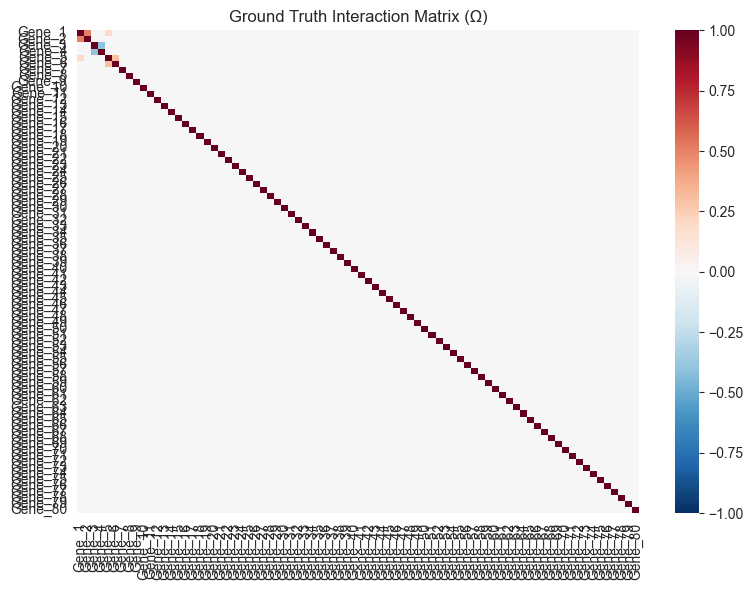

In [6]:
# Visualize the true interaction matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    true_omega,
    annot=False,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    xticklabels=gene_names,
    yticklabels=gene_names,
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Ground Truth Interaction Matrix (Ω)")
plt.tight_layout()
plt.show()

### Save and Load Data as CSV

The package supports CSV, TSV, NPY, and NPZ formats. Here we save as CSV for easy replacement with real data.

In [7]:
# Save to CSV (you can replace this file with real scRNA-seq data later)
DATA_PATH = Path("./synthetic_counts.csv")

# Create DataFrame with gene names as columns
df = pd.DataFrame(counts, columns=gene_names)
df.to_csv(DATA_PATH, index=False)

print(f"Saved count matrix to: {DATA_PATH.absolute()}")
print(f"\nFile preview:")
print(df.head())

Saved count matrix to: /Users/mcelfreg/Library/CloudStorage/OneDrive-OregonHealth&ScienceUniversity/scRNASeq_OneDrive/PreGraphModeling/python/synthetic_counts.csv

File preview:
   Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6  Gene_7  Gene_8  Gene_9  \
0       5       8      11      14       4       4      20       3       3   
1      11       0      12       3       0       6      10       4       1   
2       2       0      11       4      22       3       0       0       3   
3       2      14      19       0       1       2       0       0       0   
4       3       2       2      47       8       5      10       0       4   

   Gene_10  ...  Gene_71  Gene_72  Gene_73  Gene_74  Gene_75  Gene_76  \
0        3  ...        5        6        0        0        5       10   
1        4  ...        4        0        1        0        9        2   
2        3  ...        3        0        4        0        0        0   
3        0  ...        0        2        0        1        0       

In [8]:
# Load the count matrix using our package's loader
# This will be the main entry point when using real data

X = load_count_matrix(str(DATA_PATH), device="cpu")  # Load to CPU first

print(f"Loaded tensor shape: {X.shape}")
print(f"Tensor dtype: {X.dtype}")
print(f"Device: {X.device}")

Loaded tensor shape: torch.Size([200, 80])
Tensor dtype: torch.float32
Device: cpu


IndexError: index 8 is out of bounds for axis 0 with size 8

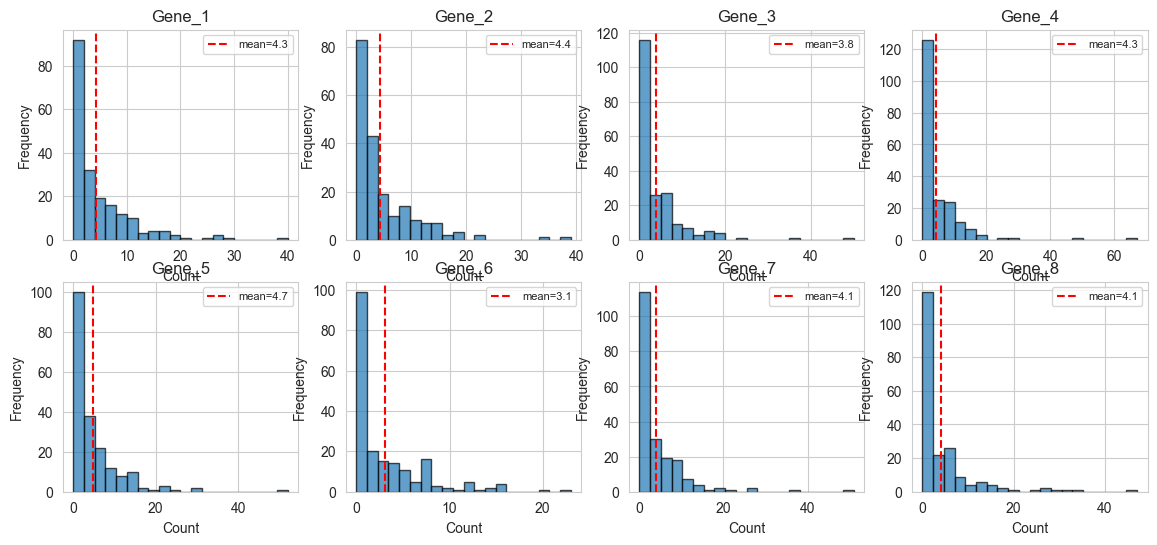

In [9]:
# Visualize count distributions
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for i, gene in enumerate(gene_names):
    ax = axes[i]
    gene_counts = counts[:, i]
    ax.hist(gene_counts, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(gene_counts.mean(), color='red', linestyle='--', label=f'mean={gene_counts.mean():.1f}')
    ax.set_xlabel('Count')
    ax.set_ylabel('Frequency')
    ax.set_title(gene)
    ax.legend(fontsize=8)

plt.suptitle('Count Distributions per Gene', fontsize=14)
plt.tight_layout()
plt.show()

<a id='model'></a>
## 4. Model Setup

### Create the ZINB Pseudo-Likelihood Graphical Model

The updated model captures interactions affecting all three ZINB parameters via a **shared latent interaction matrix Ω** and specific **scaling factors γ**:

1. **Ω (Omega)**: The core gene-gene interaction network (symmetric).
2. **Scaling Factors (γ)**: Control how strongly the network affects each parameter:
   - **γ_μ**: Scaling for Mean (μ). Default ≈ 1.0 (strong effect).
   - **γ_φ**: Scaling for Dispersion (φ).
   - **γ_π**: Scaling for Zero-Inflation (π).

This allows the model to learn, for example, that an interaction increases expression (μ) but decreases variability (φ).

In [11]:
# Try to use the best available device
# For MPS, we need to move data to the device

def setup_model_and_data(X, device):
    """
    Setup model and move data to the specified device.
    Returns model and data tensor on the device.
    """
    n_features = X.shape[1]
    
    # Create model
    model = ZINBPseudoLikelihoodGraphicalModel(
        n_features=n_features,
        device=device
    )
    
    # Move data to device
    X_device = X.to(model.device)
    
    print(f"Model initialized:")
    print(f"  - Number of features (genes): {model.n_features}")
    print(f"  - Number of interaction parameters: {model.n_interaction_params}")
    print(f"  - Device: {model.device}")
    print(f"  - Data shape: {X_device.shape}")
    
    return model, X_device

# Setup with detected device
model, X_device = setup_model_and_data(X, DEVICE)

print(f"\nPriors:")
print(f"  - A_tril (interaction params): Normal(0, 1)")
print(f"  - μ (mean): LogNormal(0, 1)")
print(f"  - φ (dispersion): LogNormal(0, 1)")
print(f"  - π (zero-inflation): Beta(1, 1) = Uniform(0, 1)")

Model initialized:
  - Number of features (genes): 80
  - Number of interaction parameters: 3160
  - Device: cpu
  - Data shape: torch.Size([200, 80])

Priors:
  - A_tril (interaction params): Normal(0, 1)
  - μ (mean): LogNormal(0, 1)
  - φ (dispersion): LogNormal(0, 1)
  - π (zero-inflation): Beta(1, 1) = Uniform(0, 1)


<a id='inference'></a>
## 5. MCMC Inference

We use the **No-U-Turn Sampler (NUTS)**, an adaptive variant of Hamiltonian Monte Carlo, to jointly infer all parameters from their posterior distributions.

**Key hyperparameters:**
- `num_samples`: Number of posterior samples to draw
- `warmup_steps`: Burn-in period for NUTS adaptation
- `target_accept_prob`: Target acceptance rate (0.8 is standard)
- `max_tree_depth`: Maximum NUTS trajectory depth

In [12]:
# Inference parameters (reduced for demo speed)
# For real analysis, increase num_samples to 1000+ and warmup_steps to 500+

NUM_SAMPLES = 100       # Number of posterior samples (increase for production)
WARMUP_STEPS = 50       # Warmup/burn-in steps (increase for production)
NUM_CHAINS = 1          # Number of MCMC chains
TARGET_ACCEPT = 0.8     # Target acceptance probability

print("Inference settings:")
print(f"  - Posterior samples: {NUM_SAMPLES}")
print(f"  - Warmup steps: {WARMUP_STEPS}")
print(f"  - Chains: {NUM_CHAINS}")
print(f"  - Target acceptance: {TARGET_ACCEPT}")
print(f"\n⚠️  For publication-quality results, use num_samples=1000+, warmup_steps=500+")

Inference settings:
  - Posterior samples: 100
  - Warmup steps: 50
  - Chains: 1
  - Target acceptance: 0.8

⚠️  For publication-quality results, use num_samples=1000+, warmup_steps=500+


In [13]:
# Run inference with MPS (or detected device)
# If MPS fails, we'll fall back to CPU

def run_inference_with_fallback(model, X_device, **kwargs):
    """
    Run inference, falling back to CPU if MPS/CUDA fails.
    """
    try:
        print(f"Running inference on {model.device}...")
        results = run_inference(model, X_device, **kwargs)
        print(f"✓ Inference completed successfully on {model.device}!")
        return results, model.device
        
    except Exception as e:
        if model.device.type != "cpu":
            print(f"\n⚠️  Inference failed on {model.device}: {e}")
            print("Falling back to CPU...\n")
            
            # Recreate model and data on CPU
            cpu_model = ZINBPseudoLikelihoodGraphicalModel(
                n_features=model.n_features,
                device="cpu"
            )
            X_cpu = X_device.cpu()
            
            print(f"Running inference on CPU...")
            results = run_inference(cpu_model, X_cpu, **kwargs)
            print(f"✓ Inference completed successfully on CPU!")
            return results, torch.device("cpu")
        else:
            raise

# Run inference
print("="*60)
print("Starting MCMC Inference")
print("="*60 + "\n")

results, actual_device = run_inference_with_fallback(
    model,
    X_device,
    num_samples=NUM_SAMPLES,
    warmup_steps=WARMUP_STEPS,
    num_chains=NUM_CHAINS,
    target_accept_prob=TARGET_ACCEPT,
)

print(f"\nInference ran on: {actual_device}")

Starting MCMC Inference

Running inference on cpu...


Warmup:   0%|          | 0/150 [00:00, ?it/s]

Sample: 100%|██████████| 150/150 [1:02:36, 25.05s/it, step size=3.19e-02, acc. prob=0.825]


✓ Inference completed successfully on cpu!

Inference ran on: cpu


### CPU Fallback Cell

If the above cell fails on MPS/CUDA, run this cell to explicitly use CPU:

In [ ]:
# FALLBACK: Run on CPU if above cell failed
# Uncomment and run this cell if needed

# model_cpu, X_cpu = setup_model_and_data(X, "cpu")
# results = run_inference(
#     model_cpu,
#     X_cpu,
#     num_samples=NUM_SAMPLES,
#     warmup_steps=WARMUP_STEPS,
#     num_chains=NUM_CHAINS,
#     target_accept_prob=TARGET_ACCEPT,
# )
# print("✓ CPU inference completed!")

<a id='posterior'></a>
## 6. Posterior Analysis

Now let's examine the posterior distributions of our inferred parameters.

In [14]:
# Extract posterior samples
samples = results["samples"]
omega_samples = results["omega_samples"]
summary = results["summary"]

print("Posterior samples available:")
for key, val in samples.items():
    print(f"  - {key}: shape {val.shape}")
print(f"  - omega_samples: shape {omega_samples.shape}")

Posterior samples available:
  - A_tril: shape torch.Size([100, 3160])
  - mu: shape torch.Size([100, 80])
  - phi: shape torch.Size([100, 80])
  - pi_zero: shape torch.Size([100, 80])
  - omega_samples: shape torch.Size([100, 80, 80])


In [15]:
# Summary statistics
print("="*60)
print("POSTERIOR SUMMARY")
print("="*60)

# Mu (mean) parameters
mu_mean = summary["mu"]["mean"]
mu_std = summary["mu"]["std"]
print(f"\nμ (Mean) parameters:")
for i, gene in enumerate(gene_names):
    print(f"  {gene}: {mu_mean[i]:.2f} ± {mu_std[i]:.2f}")

# Phi (dispersion) parameters  
phi_mean = summary["phi"]["mean"]
phi_std = summary["phi"]["std"]
print(f"\nφ (Dispersion) parameters:")
for i, gene in enumerate(gene_names):
    print(f"  {gene}: {phi_mean[i]:.2f} ± {phi_std[i]:.2f}")

# Pi (zero-inflation) parameters
pi_mean = summary["pi_zero"]["mean"]
pi_std = summary["pi_zero"]["std"]
print(f"\nπ (Zero-inflation) parameters:")
for i, gene in enumerate(gene_names):
    print(f"  {gene}: {pi_mean[i]:.3f} ± {pi_std[i]:.3f}")

POSTERIOR SUMMARY

μ (Mean) parameters:
  Gene_1: 6.07 ± 2.93
  Gene_2: 2.48 ± 1.19
  Gene_3: 2.18 ± 1.04
  Gene_4: 3.88 ± 1.55
  Gene_5: 3.01 ± 1.31
  Gene_6: 2.93 ± 1.43
  Gene_7: 4.19 ± 2.05
  Gene_8: 3.02 ± 1.35
  Gene_9: 2.05 ± 0.98
  Gene_10: 2.16 ± 1.09
  Gene_11: 1.96 ± 0.88
  Gene_12: 3.17 ± 1.66
  Gene_13: 3.05 ± 1.15
  Gene_14: 0.83 ± 0.47
  Gene_15: 4.10 ± 2.19
  Gene_16: 2.84 ± 1.29
  Gene_17: 3.90 ± 1.55
  Gene_18: 3.53 ± 1.42
  Gene_19: 3.70 ± 1.55
  Gene_20: 1.07 ± 0.55
  Gene_21: 2.58 ± 1.10
  Gene_22: 3.98 ± 1.61
  Gene_23: 1.19 ± 0.63
  Gene_24: 2.50 ± 1.57
  Gene_25: 2.40 ± 0.94
  Gene_26: 5.61 ± 1.95
  Gene_27: 2.28 ± 1.23
  Gene_28: 1.58 ± 0.75
  Gene_29: 4.80 ± 2.25
  Gene_30: 3.02 ± 1.69
  Gene_31: 4.40 ± 2.14
  Gene_32: 4.92 ± 2.56
  Gene_33: 4.68 ± 2.24
  Gene_34: 3.48 ± 1.44
  Gene_35: 2.86 ± 1.53
  Gene_36: 2.95 ± 1.56
  Gene_37: 3.55 ± 1.33
  Gene_38: 3.38 ± 1.56
  Gene_39: 3.17 ± 1.61
  Gene_40: 3.57 ± 1.66
  Gene_41: 2.79 ± 1.37
  Gene_42: 3.95 ± 1.77
  G

/var/folders/z3/8cm3bfq97jlfg1tvgxyz3b2nwd1khd/T/ipykernel_50024/1758381440.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


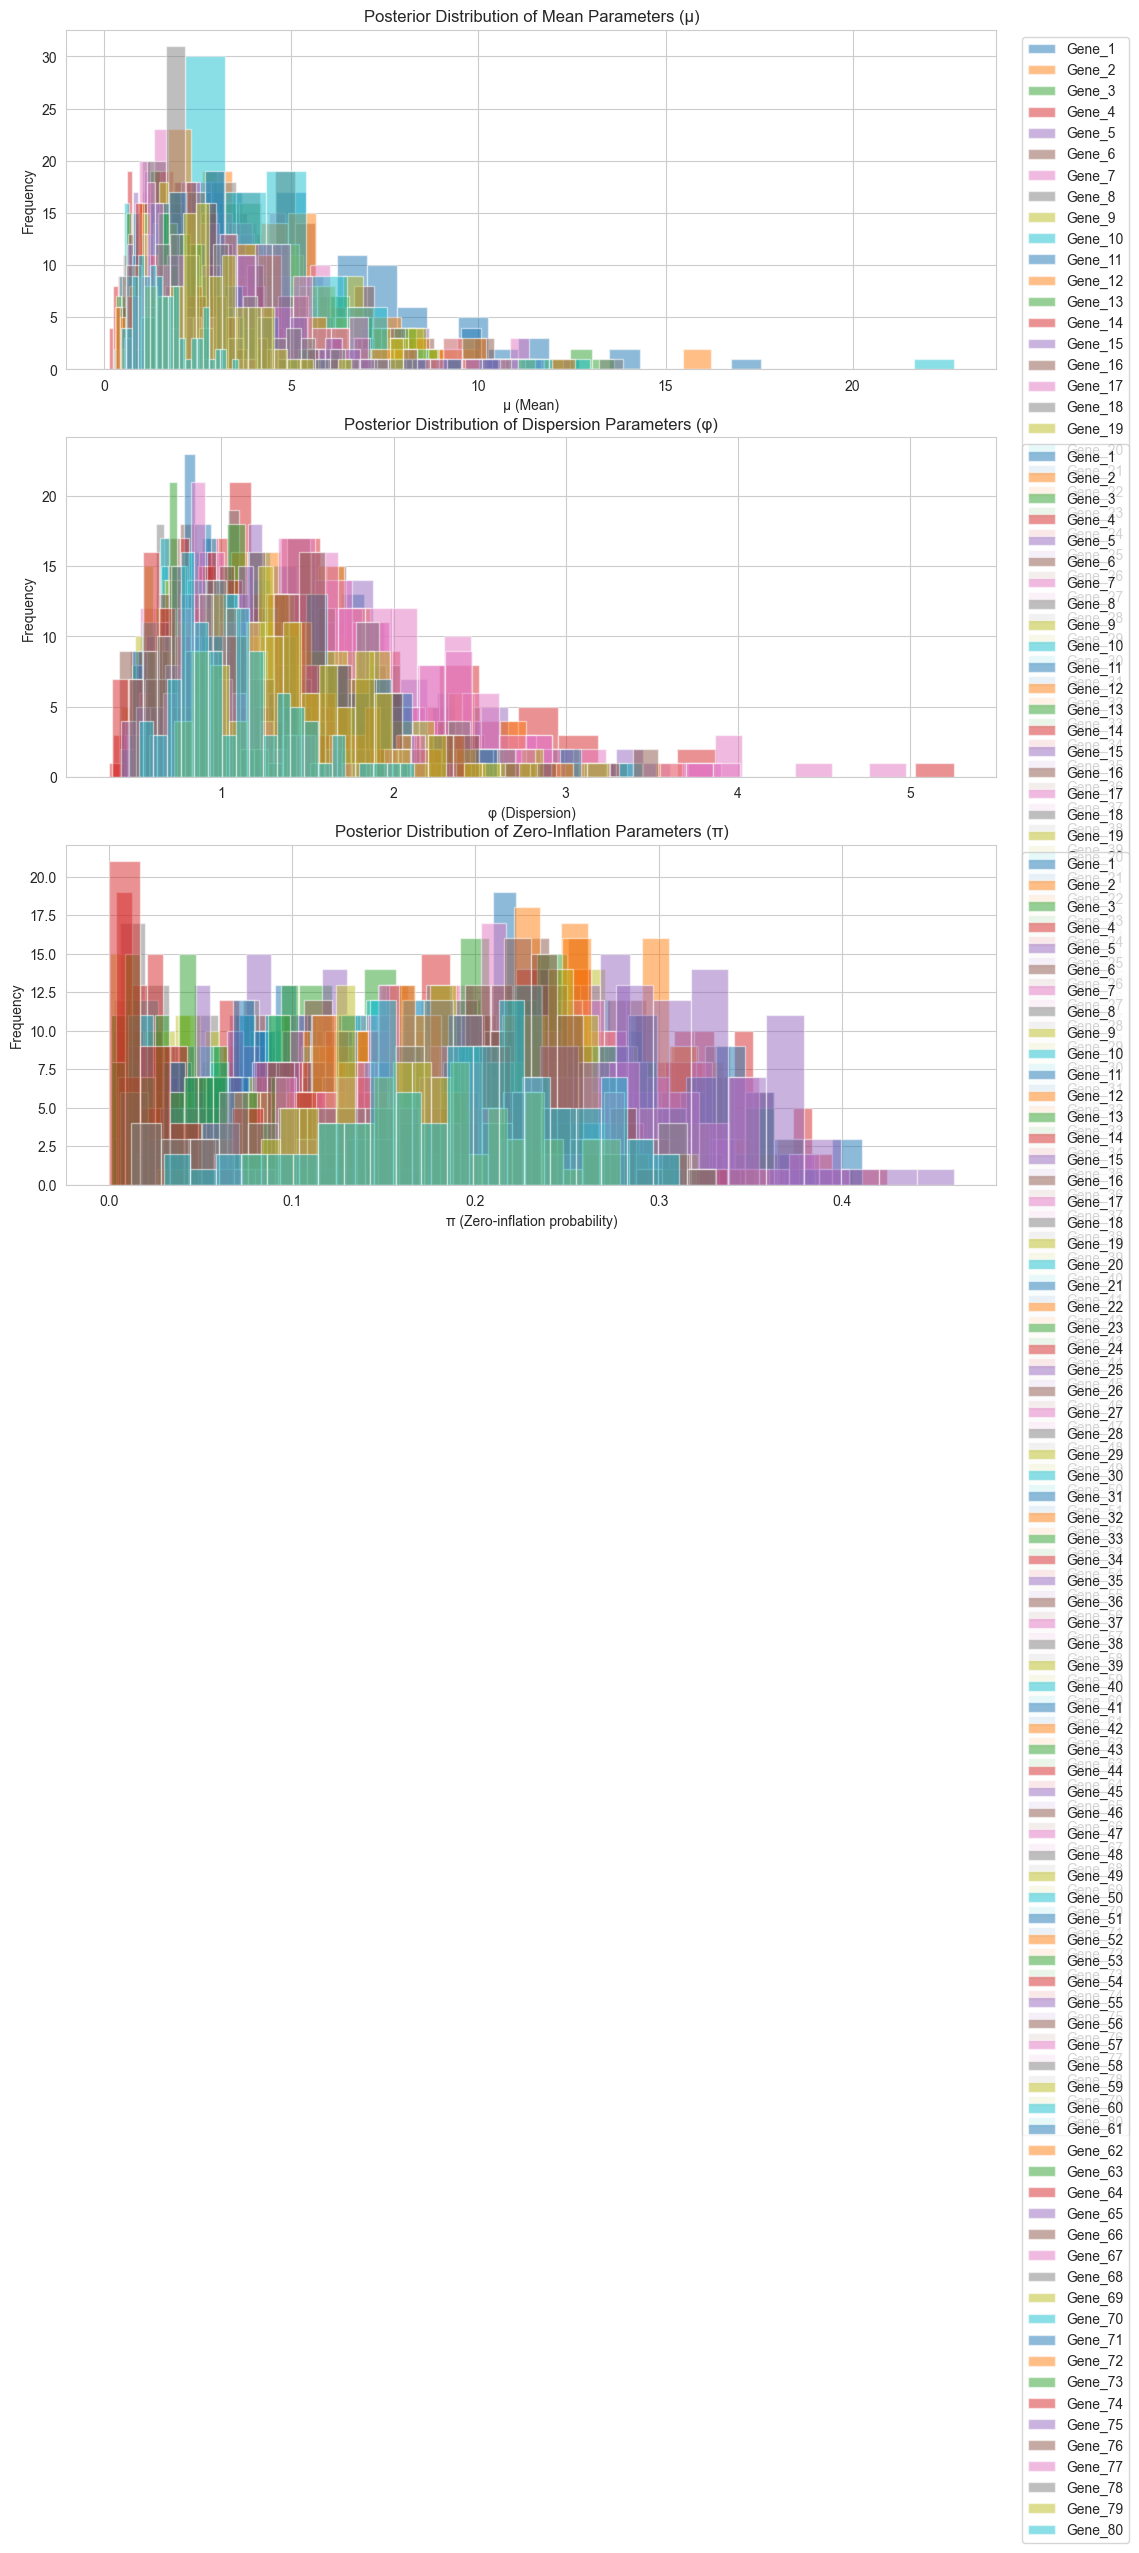

In [18]:
# Visualize posterior distributions for ZINB parameters
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Mu posteriors
ax = axes[0]
mu_samples = samples["mu"].cpu().numpy()
for i, gene in enumerate(gene_names):
    ax.hist(mu_samples[:, i], bins=20, alpha=0.5, label=gene)
ax.set_xlabel("μ (Mean)")
ax.set_ylabel("Frequency")
ax.set_title("Posterior Distribution of Mean Parameters (μ)")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Phi posteriors
ax = axes[1]
phi_samples = samples["phi"].cpu().numpy()
for i, gene in enumerate(gene_names):
    ax.hist(phi_samples[:, i], bins=20, alpha=0.5, label=gene)
ax.set_xlabel("φ (Dispersion)")
ax.set_ylabel("Frequency")
ax.set_title("Posterior Distribution of Dispersion Parameters (φ)")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Pi posteriors
ax = axes[2]
pi_samples = samples["pi_zero"].cpu().numpy()
for i, gene in enumerate(gene_names):
    ax.hist(pi_samples[:, i], bins=20, alpha=0.5, label=gene)
ax.set_xlabel("π (Zero-inflation probability)")
ax.set_ylabel("Frequency")
ax.set_title("Posterior Distribution of Zero-Inflation Parameters (π)")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Visualize Gamma Scaling Factors
gamma_mu = samples['gamma_mu'].cpu().numpy().flatten()
gamma_phi = samples['gamma_phi'].cpu().numpy().flatten()
gamma_pi = samples['gamma_pi'].cpu().numpy().flatten()

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(gamma_mu, fill=True, label=f'γ_μ (Mean): {gamma_mu.mean():.2f} ± {gamma_mu.std():.2f}', ax=ax)
sns.kdeplot(gamma_phi, fill=True, label=f'γ_φ (Dispersion): {gamma_phi.mean():.2f} ± {gamma_phi.std():.2f}', ax=ax)
sns.kdeplot(gamma_pi, fill=True, label=f'γ_π (Zero-Infl): {gamma_pi.mean():.2f} ± {gamma_pi.std():.2f}', ax=ax)

ax.axvline(1.0, color='gray', linestyle='--', alpha=0.5, label='Expected γ_μ ≈ 1')
ax.axvline(0.0, color='gray', linestyle=':', alpha=0.5, label='Indep. (γ ≈ 0)')

ax.set_title("Posterior Distribution of Scaling Factors (γ)")
ax.set_xlabel("Scaling Factor Value")
ax.legend()
plt.tight_layout()
plt.show()

print("Recovered Scaling Factors:")
print(f"  γ_μ (True={1.0}): {gamma_mu.mean():.3f}")
print(f"  γ_φ (True={0.5}): {gamma_phi.mean():.3f}")
print(f"  γ_π (True={-0.5}): {gamma_pi.mean():.3f}")

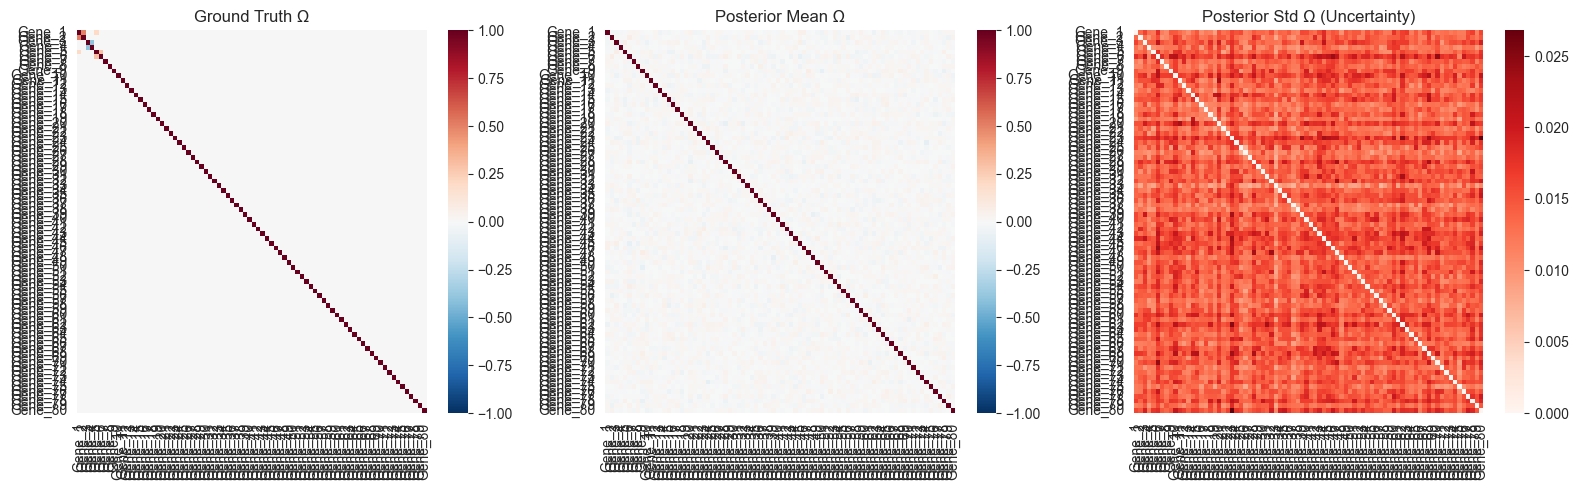

In [20]:
# Omega posterior mean and comparison to ground truth
omega_mean = summary["omega"]["mean"]
omega_std = summary["omega"]["std"]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ground truth
ax = axes[0]
sns.heatmap(
    true_omega,
    annot=False,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    xticklabels=gene_names,
    yticklabels=gene_names,
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Ground Truth Ω")

# Posterior mean
ax = axes[1]
sns.heatmap(
    omega_mean,
    annot=False,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    xticklabels=gene_names,
    yticklabels=gene_names,
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Posterior Mean Ω")

# Posterior std (uncertainty)
ax = axes[2]
sns.heatmap(
    omega_std,
    annot=False,
    fmt=".2f",
    cmap="Reds",
    xticklabels=gene_names,
    yticklabels=gene_names,
    ax=ax,
)
ax.set_title("Posterior Std Ω (Uncertainty)")

plt.tight_layout()
plt.show()

<a id='network-inference'></a>
## 7. Network Inference from Ω

The inferred **Ω matrix** represents a gene-gene interaction network. Each off-diagonal element Ω[i,j] indicates the conditional dependency between genes i and j.

To extract a network:
1. Use the posterior mean of Ω
2. Apply a threshold to identify significant edges
3. Optionally use credible intervals to assess confidence

In [21]:
def extract_network_edges(
    omega_mean: np.ndarray,
    omega_std: np.ndarray,
    gene_names: list,
    threshold: float = 0.1,
    use_credible_interval: bool = True,
    alpha: float = 0.05,
):
    """
    Extract network edges from the posterior Omega matrix.
    
    Parameters:
    -----------
    omega_mean : np.ndarray
        Posterior mean of Omega matrix
    omega_std : np.ndarray
        Posterior standard deviation of Omega matrix
    gene_names : list
        Names of genes
    threshold : float
        Minimum absolute value for an edge to be included
    use_credible_interval : bool
        If True, only include edges where credible interval excludes zero
    alpha : float
        Significance level for credible interval (uses normal approximation)
        
    Returns:
    --------
    edges : list of tuples
        List of (gene_i, gene_j, weight, significant) tuples
    adjacency : np.ndarray
        Binary adjacency matrix
    """
    from scipy import stats
    
    n_genes = len(gene_names)
    z_crit = stats.norm.ppf(1 - alpha/2)  # Two-tailed
    
    edges = []
    adjacency = np.zeros((n_genes, n_genes))
    
    for i in range(n_genes):
        for j in range(i+1, n_genes):  # Upper triangle only (symmetric)
            weight = omega_mean[i, j]
            std = omega_std[i, j]
            
            # Check threshold
            if abs(weight) < threshold:
                continue
            
            # Check credible interval
            if use_credible_interval:
                lower = weight - z_crit * std
                upper = weight + z_crit * std
                significant = (lower > 0) or (upper < 0)  # CI excludes zero
            else:
                significant = True
            
            if significant:
                edges.append({
                    'gene_i': gene_names[i],
                    'gene_j': gene_names[j],
                    'weight': weight,
                    'std': std,
                    'type': 'positive' if weight > 0 else 'negative'
                })
                adjacency[i, j] = 1
                adjacency[j, i] = 1
    
    return edges, adjacency

# Extract edges with default settings
edges, adjacency = extract_network_edges(
    omega_mean,
    omega_std,
    gene_names,
    threshold=0.05,
    use_credible_interval=True,
    alpha=0.05,
)

print(f"Extracted {len(edges)} significant edges from the network:")
print()

edges_df = pd.DataFrame(edges)
if len(edges) > 0:
    edges_df = edges_df.sort_values('weight', key=abs, ascending=False)
    print(edges_df.to_string(index=False))
else:
    print("No edges met the significance criteria.")
    print("Try lowering the threshold or running more MCMC samples.")

Extracted 77 significant edges from the network:

 gene_i  gene_j    weight      std     type
Gene_24 Gene_74 -0.087429 0.016434 negative
 Gene_6 Gene_45 -0.081697 0.021273 negative
 Gene_9 Gene_50 -0.079968 0.017137 negative
 Gene_9 Gene_47  0.076259 0.014630 positive
Gene_39 Gene_48 -0.075682 0.014410 negative
Gene_20 Gene_28 -0.074589 0.018640 negative
Gene_23 Gene_42  0.071977 0.015335 positive
 Gene_2  Gene_6  0.069926 0.015796 positive
Gene_20 Gene_32 -0.067665 0.017364 negative
Gene_28 Gene_46 -0.066643 0.019040 negative
 Gene_6 Gene_54  0.066000 0.018781 positive
 Gene_2 Gene_56 -0.063857 0.014403 negative
 Gene_9 Gene_78 -0.063675 0.017452 negative
 Gene_3  Gene_5  0.063554 0.014367 positive
Gene_61 Gene_70 -0.063541 0.017565 negative
Gene_15 Gene_58 -0.063021 0.015865 negative
 Gene_5 Gene_15 -0.061247 0.016131 negative
Gene_54 Gene_56 -0.061234 0.015798 negative
Gene_24 Gene_50  0.061166 0.014518 positive
Gene_62 Gene_74  0.061133 0.015998 positive
Gene_43 Gene_62 -0.060914 

In [22]:
# Compare inferred edges to ground truth
print("\n" + "="*60)
print("COMPARISON: Inferred vs Ground Truth Interactions")
print("="*60)

# Ground truth edges (non-zero off-diagonal)
true_edges = []
for i in range(N_GENES):
    for j in range(i+1, N_GENES):
        if true_omega[i, j] != 0:
            true_edges.append({
                'gene_i': gene_names[i],
                'gene_j': gene_names[j],
                'true_weight': true_omega[i, j],
            })

print(f"\nGround truth has {len(true_edges)} non-zero interactions:")
for e in true_edges:
    print(f"  {e['gene_i']} -- {e['gene_j']}: {e['true_weight']:.2f}")

print(f"\nInferred network has {len(edges)} significant edges.")


COMPARISON: Inferred vs Ground Truth Interactions

Ground truth has 4 non-zero interactions:
  Gene_1 -- Gene_2: 0.50
  Gene_1 -- Gene_5: 0.20
  Gene_3 -- Gene_4: -0.40
  Gene_5 -- Gene_6: 0.30

Inferred network has 77 significant edges.


<a id='network-analysis'></a>
## 8. Network Analysis with NetworkX

Now let's build a proper network graph and compute network metrics.

In [23]:
def build_gene_network(omega_mean: np.ndarray, gene_names: list, threshold: float = 0.05):
    """
    Build a NetworkX graph from the Omega interaction matrix.
    
    Parameters:
    -----------
    omega_mean : np.ndarray
        Posterior mean of Omega matrix
    gene_names : list
        Names of genes
    threshold : float
        Minimum absolute weight for edge inclusion
        
    Returns:
    --------
    G : nx.Graph
        NetworkX graph with weighted edges
    """
    G = nx.Graph()
    
    # Add all genes as nodes
    G.add_nodes_from(gene_names)
    
    # Add edges from Omega
    n_genes = len(gene_names)
    for i in range(n_genes):
        for j in range(i+1, n_genes):
            weight = omega_mean[i, j]
            if abs(weight) >= threshold:
                G.add_edge(
                    gene_names[i],
                    gene_names[j],
                    weight=weight,
                    abs_weight=abs(weight),
                    edge_type='positive' if weight > 0 else 'negative'
                )
    
    return G

# Build the network
G = build_gene_network(omega_mean, gene_names, threshold=0.05)

print(f"Network Statistics:")
print(f"  Nodes (genes): {G.number_of_nodes()}")
print(f"  Edges (interactions): {G.number_of_edges()}")
print(f"  Density: {nx.density(G):.3f}")

if G.number_of_edges() > 0:
    print(f"  Connected components: {nx.number_connected_components(G)}")

Network Statistics:
  Nodes (genes): 80
  Edges (interactions): 77
  Density: 0.024
  Connected components: 30


In [24]:
# Compute node centrality measures
if G.number_of_edges() > 0:
    # Degree centrality
    degree_cent = nx.degree_centrality(G)
    
    # Betweenness centrality (for larger networks)
    betweenness_cent = nx.betweenness_centrality(G)
    
    # Eigenvector centrality (if connected)
    try:
        eigen_cent = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        eigen_cent = {n: 0 for n in G.nodes()}
    
    # Create centrality DataFrame
    centrality_df = pd.DataFrame({
        'Gene': list(degree_cent.keys()),
        'Degree': [G.degree(n) for n in degree_cent.keys()],
        'Degree_Centrality': list(degree_cent.values()),
        'Betweenness': list(betweenness_cent.values()),
        'Eigenvector': list(eigen_cent.values()),
    }).sort_values('Degree', ascending=False)
    
    print("Gene Centrality Measures:")
    print(centrality_df.to_string(index=False))
    
    # Identify hub genes (top centrality)
    hub_genes = centrality_df.nlargest(3, 'Degree')['Gene'].tolist()
    print(f"\nPotential hub genes: {', '.join(hub_genes)}")
else:
    print("No edges in network - cannot compute centralities")

Gene Centrality Measures:
   Gene  Degree  Degree_Centrality  Betweenness  Eigenvector
 Gene_6       8           0.101266     0.097655 4.011147e-01
Gene_28       7           0.088608     0.064366 3.881103e-01
Gene_15       6           0.075949     0.060114 7.177145e-02
Gene_50       6           0.075949     0.042905 1.857806e-01
Gene_78       5           0.063291     0.052988 2.689996e-01
Gene_20       5           0.063291     0.040967 3.132963e-01
 Gene_9       5           0.063291     0.035431 2.570992e-01
Gene_54       5           0.063291     0.051519 1.899389e-01
Gene_62       4           0.050633     0.021969 1.847288e-01
Gene_31       4           0.050633     0.019204 2.034682e-01
Gene_43       4           0.050633     0.023420 2.089465e-01
Gene_45       4           0.050633     0.038535 1.513667e-01
Gene_23       4           0.050633     0.022296 5.359787e-02
Gene_58       4           0.050633     0.030870 5.974930e-02
Gene_68       4           0.050633     0.003551 1.460975e-0

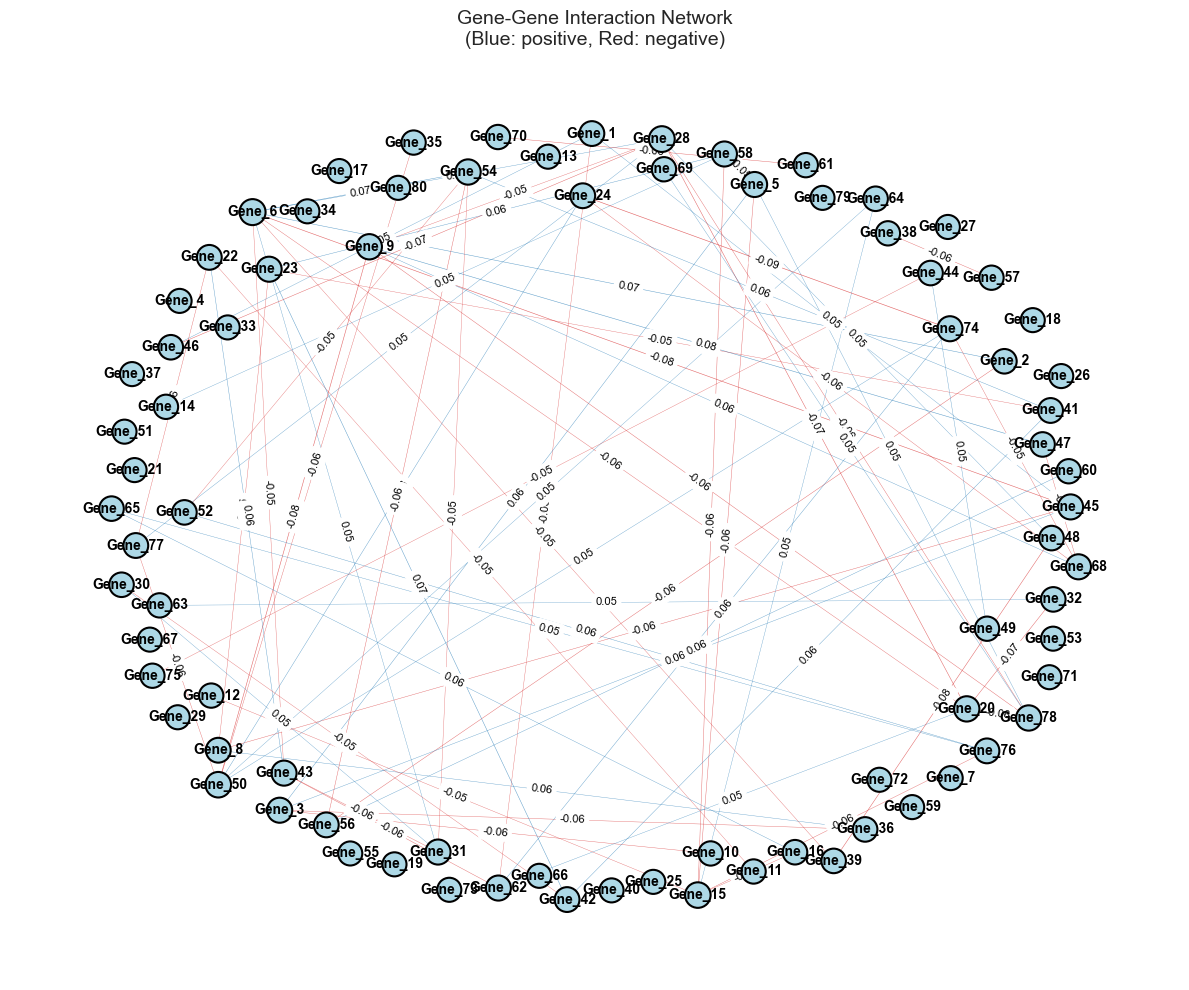

In [25]:
# Visualize the network
fig, ax = plt.subplots(figsize=(12, 10))

if G.number_of_edges() > 0:
    # Layout
    pos = nx.spring_layout(G, seed=42, k=2)
    
    # Edge colors: red for negative, blue for positive
    edge_colors = ['#d62728' if G[u][v]['weight'] < 0 else '#1f77b4' 
                   for u, v in G.edges()]
    
    # Edge widths proportional to absolute weight
    edge_weights = [abs(G[u][v]['weight']) * 5 for u, v in G.edges()]
    
    # Node sizes proportional to degree
    node_sizes = [300 + 500 * degree_cent[n] for n in G.nodes()]
    
    # Draw network
    nx.draw_networkx_nodes(
        G, pos, 
        node_size=node_sizes,
        node_color='lightblue',
        edgecolors='black',
        linewidths=1.5,
        ax=ax
    )
    
    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_colors,
        width=edge_weights,
        alpha=0.7,
        ax=ax
    )
    
    nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold',
        ax=ax
    )
    
    # Add edge labels with weights
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, ax=ax)
    
    ax.set_title("Gene-Gene Interaction Network\n(Blue: positive, Red: negative)", fontsize=14)
else:
    # Draw just nodes if no edges
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    ax.set_title("Gene Network (No significant interactions detected)", fontsize=14)

ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# Export network for external analysis (e.g., R/igraph, Cytoscape)
if G.number_of_edges() > 0:
    # Export edge list
    edge_list_path = Path("./gene_network_edges.csv")
    
    edge_data = []
    for u, v, data in G.edges(data=True):
        edge_data.append({
            'source': u,
            'target': v,
            'weight': data['weight'],
            'abs_weight': data['abs_weight'],
            'type': data['edge_type']
        })
    
    edge_df = pd.DataFrame(edge_data)
    edge_df.to_csv(edge_list_path, index=False)
    
    print(f"Exported edge list to: {edge_list_path.absolute()}")
    print(f"\nThis file can be imported into:")
    print(f"  - R with: edges <- read.csv('{edge_list_path}')")
    print(f"  - igraph: g <- graph_from_data_frame(edges)")
    print(f"  - Cytoscape: File → Import → Network from File")
else:
    print("No edges to export.")

Exported edge list to: /Users/mcelfreg/Library/CloudStorage/OneDrive-OregonHealth&ScienceUniversity/scRNASeq_OneDrive/PreGraphModeling/python/gene_network_edges.csv

This file can be imported into:
  - R with: edges <- read.csv('gene_network_edges.csv')
  - igraph: g <- graph_from_data_frame(edges)
  - Cytoscape: File → Import → Network from File


## Summary

This notebook demonstrated:

1. **Installation** of the `zinb_graphical_model` package from local source
2. **Device detection** for Mac Silicon (MPS), CUDA, or CPU with automatic fallback
3. **Data preparation** with synthetic scRNA-seq-like counts saved to CSV
4. **Model setup** with the `ZINBPseudoLikelihoodGraphicalModel`
5. **MCMC inference** using NUTS for joint parameter estimation
6. **Posterior analysis** of μ, φ, π, and Ω parameters
7. **Network inference** from the Ω interaction matrix
8. **Network analysis** with NetworkX (centrality, visualization)

### Next Steps

- Replace `synthetic_counts.csv` with real scRNA-seq data
- Increase `num_samples` and `warmup_steps` for production runs
- Export to R for advanced igraph analysis
- Integrate with the R `PreGraphModeling` package for RBM modeling

In [ ]:
# Clean up generated files (optional)
# Uncomment to remove temporary files

# import os
# if DATA_PATH.exists():
#     os.remove(DATA_PATH)
#     print(f"Removed {DATA_PATH}")
# 
# if edge_list_path.exists():
#     os.remove(edge_list_path)
#     print(f"Removed {edge_list_path}")